# Assignment 1
**Samuel Sheehy (Student ID 18143565)**

**Techniques of High Performance Computing (PHAS0102)**

**MSc Scientific Computing, University College London**, **2019-2020**

## Setup Notebook
Here we import libraries that will be used for the completion of both questions.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit, prange

## Question 1: Random Walk on a Lattice
The objective is to estimate the probability function of a particle reaching the bottom edge of a lattice as it moves randomly over the lattice. In a fist instance, I implemented a version of the code with no concern for speed, which I then optimised for performance. Only the optimised version is presented here.

The following conventions are set explicitly for reference during the implementation:
* 0 is North, 1 is East, 2 is South, 3 is West
* Moving North decreases position, moving East increases position
* Longitudinal movement is index 0, Latteral movement is index 1
* A run will only finish when a particle reaches an edge
* A run is considered a success when the particle has reached the bottom edge. Otherwise it is considered a failure.

The approach to optimising the code was to consider methods that would both increase execution speed and reduce down time on any of the processors. Thus, instead of performing a run consisting of a sinlge particle placed on the lattice, in a run each lattice point is initialised with particle and a set of random movements is applied to all the particles simultaneously. This allows the algorithm to make use of efficient implementations of vector addition. As the particles progress in their random walks, when one reaches an edge, it is removed from the next round of step execution. This ensures that points to do keep moving once they have reached an edge and that the code is not performing additions on particles that cannot move anyway.

The code is implemented using ```numba```'s JIT compiler. This tool allows the code to run fast and it makes available Numba's parallel processing feature. The ```numexpr``` library was considered for this implementation, but while Numexpr has multicore abilities when Intel's MLK libraries are installed, this is not guaranteed to be the case on every machine. Because ```numexpr``` is nor compatible with ```numba```, this meant that it could not be used in this implementation. Python's ```multiprocessing``` library was also considered; however, considering the simplicity of this program, the overhead for using these features was too high, especially when numba'a automatic parallelisation feature is available.

First the code is presented followed by an analysis of lattice's convergence.

### Perfomance-Optimised Code

In [2]:
#                                                                 #
#     Performance-Optimised Implementation of a Random Walk       # 
#                                                                 #
#                                                                 #

@njit(['float64[:,:](int64)'])
def initialise_starting_points(size):
    """
    Create a set of vectors representing every point
    on the lattice. These are generated all at once so that
    the program can apply steps to each particle in one
    vector addition. This is faster than following only one
    particle at a time.
    """
    number_of_points = size**2
    indexes = np.arange(number_of_points)
    starting_points = np.empty((number_of_points, 2))
    starting_points[:, 0] = indexes%size # Generates column indexes
    starting_points[:, 1] = indexes//size # Generates row indexes
    return starting_points


@njit(['float64[:,:](int64)'])
def generate_random_steps(number_of_points):
    """
    Generate a set of random steps. Numba did not seem
    to support an integer being used to select entries
    from a smaller matrix, so to enable vector-wise generation
    of random steps, this function implements trigonometric functions.
    """
    steps = np.zeros((number_of_points, 2))
    output = np.empty_like(steps)
    directions = np.random.randint(0, 4, (number_of_points))
    steps[:, 0] = np.cos(directions/4*2*np.pi)
    steps[:, 1] = np.sin(directions/4*2*np.pi)
    np.round(steps, 1, output)
    return output
    

@njit(['float64[:,:](float64[:,:], float64[:,:])'])
def step(particles, steps):
    """
    Peform a step on the given particles, returning their new
    position.
    """
    return particles+steps
    
    

@njit(['float64[:,:](float64[:,:])'])
def step_randomly(particles):
    """
    Perform a step in a random direction for each respective
    point provided to the function.
    """
    number_of_points = len(particles)
    steps = generate_random_steps(number_of_points)
    return step(particles, steps)


@njit(['float64[:](float64[:,:], int64)'])
def get_states(particles, size):
    """
    Determine the state of each particle provided: is it on the lower
    border, a different border, or on none.
    """
    states = np.zeros((size**2, 1))
    actual_width = particles[:, 0]
    actual_height = particles[:, 1]
    on_south = actual_height >= (size-1)
    on_north = actual_height <= 0
    on_east = actual_width >= (size-1) 
    on_west = actual_width <= 0 
    states[on_north | on_east | on_west] = 1
    states[on_south] = 2
    return states.flatten() # Return a 1-D array


@njit(['float64[:,:](float64[:,:], int64)'])
def random_walk(particles, size):
    """
    Perform a run on every point in the lattice, by repeatidly stepping
    the points in random directions. Once a particle has reached
    a "finished" state (i.e. it has reached a border), it is filtered
    out from performing new steps to avoid pointless calculations and
    gain some computational efficiency.
    """
    states = get_states(particles, size)
    while particles[states == 0].size > 0:
        particles[states == 0] = step_randomly(particles[states == 0])
        states = get_states(particles, size)
    return particles


@njit(['float64[:](float64[:,:], int64)'])
def get_success(particles, size):
    """
    Determine if the particle has succeeded in reaching the bottom
    edge. 
    """
    states = get_states(particles, size)
    successes = states >= 2 # In the final addition of all the states
                            # the bottom-left and bottom-right corners
                            # come to 3, so the greater-than symbold 
                            # ensures they are included in the success
                            # scale
    return successes*1.0 # Converts from integer to float


@njit(['float64[:,:](int64, int64)'], parallel=True)
def measure_success(iterations, size):
    """
    Perform the measurement of the success rate on all points
    of the lattice for the given number of iterations. This
    implements ```numba```'s automatic parallelisation feature,
    so that multiple experiments can run concurrently.
    """
    # Initialise results container
    results = np.zeros((size**2,), dtype=np.double)
    # Parallel-section
    for _ in prange(iterations):
        # Setup
        particles = initialise_starting_points(size)
        # Run Measurment
        particles = random_walk(particles, size)
        # Save results
        results += get_success(particles, size)
    # Transform number of successes into a fraction based on
    # the total number of runs
    results = results.reshape(size, size)/iterations
    return results


def show_success_map(results_matrix):
    """
    Creates a heatmap of the results using pyplot's imshow. The numbers
    are automatically scaled to fit the colormap.
    """
    plt.imshow(results_matrix, cmap='hot', interpolation='nearest')
    plt.colorbar()
    plt.show()   

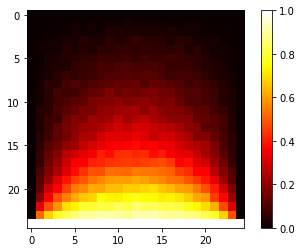

In [3]:
# Run an example of the alogrithm and display the output
size = 25
iterations = 1000
results = measure_success(iterations, size)
show_success_map(results)

In [4]:
# Measure the execution time of the main section of the
# procedure
%timeit measure_success(iterations, size)

8.02 s ± 333 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Convergence

In this section we study the convergence of the execution time of the algorithm: first as it increases in iteration count, then as it increases in size.

The method for determining convergence is to measure the absolute difference between respective values of two neighboring runs. The results from the Nth+1 run are subtracted from the results from the Nth run and the largest in magnitude of these differences is recorded.

These values are then plotted against their respective iteration or size count in order to discern the convergence behaviour. For comparison between different lattice sizes, lattice increments are done in steps of 5. This allows for each new lattice to be reduced back to a 5x5 dimension, averaging corresponding cells together. 

Commentary on this behaviour follows the display of the plots.

The convergence of the number of random walks is measured for a constant lattice size of side-length 20. The convergence of the lattice size is measured for a constant number of iterations of 2000.

In [26]:
# Code to measure the convergence of the Random Walk alogrithm
def multirun_Q1(start, end, step, parameter):
    """
    Run the algorithm multiple times changing the specified parameter
    through the range given with the step given.
    """
    # Defualt parameters
    iterations = 2000
    size = 10
    
    results = []
    iterates = np.linspace(start, end, step)
    for value in iterates:
        if parameter == 'size':
            size = int(value)
        elif parameter == 'iterations':
            iterations = int(value)
        else:
            return
        results.append(
            measure_success(iterations, size)
        )
    return iterates, results


def difference_calculate(iterates, results):
    """
    Get the largest absolute difference between a set of results from
    one run and the set of results from the previous run.
    """
    diff = [np.linalg.norm(results[i] - results[i+1], np.inf) for i in range(1, len(results)-1)]
    return iterates[1:-1], diff

## -----------------------------------------------------------
## Uncomment this section to re-run convergence measurements
## -----------------------------------------------------------
# iterations_space, multi_iterations = multirun_Q1(10, 7000, 100, 'iterations')
# sizes, multi_size = multirun_Q1(5, 60, 12, 'size')
#
# multi_size_refactored = [result.reshape(5, (size+1)**2, 5).mean(axis=1)
#                     for size, result in zip(range(len(multi_size)), multi_size)]
#
# iter_space_plot, multi_iter_plot = difference_calculate(iterations_space, multi_iterations)
# sizes_space_plot, multi_sizes_plot = difference_calculate(sizes, multi_size_refactored)
## -----------------------------------------------------------

#### Saved Convergence Measurements
In the following cell, data generated by the above convergence measurement functions is copied for the sake of quick reproduction.

In [3]:
iter_space_plot = np.array([  80.60606061,  151.21212121,  221.81818182,  292.42424242,
        363.03030303,  433.63636364,  504.24242424,  574.84848485,
        645.45454545,  716.06060606,  786.66666667,  857.27272727,
        927.87878788,  998.48484848, 1069.09090909, 1139.6969697 ,
       1210.3030303 , 1280.90909091, 1351.51515152, 1422.12121212,
       1492.72727273, 1563.33333333, 1633.93939394, 1704.54545455,
       1775.15151515, 1845.75757576, 1916.36363636, 1986.96969697,
       2057.57575758, 2128.18181818, 2198.78787879, 2269.39393939,
       2340.        , 2410.60606061, 2481.21212121, 2551.81818182,
       2622.42424242, 2693.03030303, 2763.63636364, 2834.24242424,
       2904.84848485, 2975.45454545, 3046.06060606, 3116.66666667,
       3187.27272727, 3257.87878788, 3328.48484848, 3399.09090909,
       3469.6969697 , 3540.3030303 , 3610.90909091, 3681.51515152,
       3752.12121212, 3822.72727273, 3893.33333333, 3963.93939394,
       4034.54545455, 4105.15151515, 4175.75757576, 4246.36363636,
       4316.96969697, 4387.57575758, 4458.18181818, 4528.78787879,
       4599.39393939, 4670.        , 4740.60606061, 4811.21212121,
       4881.81818182, 4952.42424242, 5023.03030303, 5093.63636364,
       5164.24242424, 5234.84848485, 5305.45454545, 5376.06060606,
       5446.66666667, 5517.27272727, 5587.87878788, 5658.48484848,
       5729.09090909, 5799.6969697 , 5870.3030303 , 5940.90909091,
       6011.51515152, 6082.12121212, 6152.72727273, 6223.33333333,
       6293.93939394, 6364.54545455, 6435.15151515, 6505.75757576,
       6576.36363636, 6646.96969697, 6717.57575758, 6788.18181818,
       6858.78787879, 6929.39393939])

multi_iter_plot = np.array([0.4614855146184143,
 0.348490373618338,
 0.2908446852063044,
 0.242954951574245,
 0.24116603516721305,
 0.17972288670815995,
 0.1184143623433694,
 0.18193453825204267,
 0.16466496846362305,
 0.16675149527253455,
 0.14620825915933935,
 0.13971929959567483,
 0.15538772334565368,
 0.12356305193221186,
 0.12831147323000658,
 0.12490770545722148,
 0.12241093622154493,
 0.11416909043927059,
 0.11177077996099144,
 0.13259558978506666,
 0.1181717462756813,
 0.10133866687717685,
 0.1178260061044267,
 0.09900726407165242,
 0.08211172936906509,
 0.08794514787914641,
 0.09984401496371723,
 0.10823998710845777,
 0.10092592161520636,
 0.08907058279114947,
 0.10609507010626115,
 0.0937785360046175,
 0.08398188852459558,
 0.09321103374651928,
 0.07936585820036489,
 0.066250135397464,
 0.08391504939718428,
 0.08449486898354078,
 0.1022670550183703,
 0.09139306915824857,
 0.06340662166938642,
 0.07277635650734769,
 0.08108716976600532,
 0.07195112354428573,
 0.06310694314018932,
 0.07124158980939249,
 0.07404673739356712,
 0.07148449614992636,
 0.06796397507504777,
 0.07021067966930215,
 0.07558798367318259,
 0.06334621872037126,
 0.05625510534671541,
 0.07316205458516636,
 0.07873129032934596,
 0.07141154260786084,
 0.0658275590243414,
 0.06571355128180156,
 0.06354989218653695,
 0.06408333372551747,
 0.06823089530397827,
 0.06500874633574166,
 0.062437592482098035,
 0.06377719430731238,
 0.05324172216663007,
 0.05777808572741314,
 0.0529561978306883,
 0.05567110784089908,
 0.05076858433122011,
 0.05892576503330021,
 0.05949898623926143,
 0.05368913712597045,
 0.05005093709297611,
 0.06018807186278423,
 0.0609691877530439,
 0.06337866859365039,
 0.05546226477982872,
 0.06541134193512811,
 0.049197146456607506,
 0.04995651321980503,
 0.05160318863026369,
 0.055662419420436815,
 0.049985188715228064,
 0.05630030825023304,
 0.044240818430386214,
 0.0558060995171237,
 0.05790152262972855,
 0.05021480742812692,
 0.05250849225030129,
 0.049062799154832346,
 0.046049977867009165,
 0.05318222258938345,
 0.06084841504390516,
 0.056663218200569146,
 0.05345445923855237,
 0.048495149810812405,
 0.05059005145158801,
 0.05600290199853859])

sizes_space_plot = np.array([10., 15., 20., 25., 30., 35., 40., 45., 50., 55.])

multi_sizes_plot = np.array([0.14723150848595343,
 0.05473922564812484,
 0.034160770103475506,
 0.021357990394784348,
 0.010830259102209297,
 0.015902257598804818,
 0.006826354292443264,
 0.007281961196201229,
 0.00453557005731686,
 0.0056218144388939075])

#### Convergence Plotting
Here we plot the convergence results calculated above.  

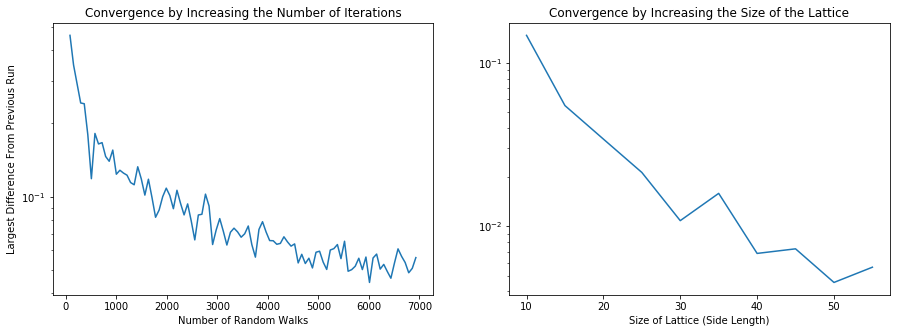

In [17]:
# Plot the convergence plots
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=False)
ax1.semilogy(iter_space_plot, multi_iter_plot)
ax1.set_xlabel('Number of Random Walks')
ax1.set_title('Convergence by Increasing the Number of Iterations')
ax2.semilogy(sizes_space_plot, multi_sizes_plot)
ax2.set_xlabel('Size of Lattice (Side Length)')
ax2.set_title('Convergence by Increasing the Size of the Lattice')
ax1.set_ylabel('Largest Difference From Previous Run');
fig.set_size_inches(15, 5)

#### Analysis of Convergence Results
The plots above illustrate the convergence behviour of the algorithm.

In regards to the number of iterations, while there is some variability of the differences between iterations (owing to the nature of the random walk), the trend shows that increasing the number of walks decreases the variability in the results. From approximately 5,000 iterations, the general trend seems to stabilise to a constant difference of 0.06 in between runs.

By increasing the size of the lattice, this has a much stronger impact on the convergence of the differences. At around a lattice size of 50, the difference from the previous run converges to about 0.006.

## Question 2: Potentials Generated by Random Particles
The algorithm here estimates the potential of a collection of particles on a point at a distance away from the centre of these points. The problem was first implemented in Python with no consideration for performance. This code was then optimised for speed and is presented below.

In the first implementation of the calculation, there were three nested loops identified: one repeating over several iterations, one repeating for different values of the radius, and one for every measurement point on a radius.

To optimise the process, the inner most loop was flattened into the middle loop, effectively considering all measurement points across all the radius values in the same iteration.

Similarly to _Q1,_ we wanted to use Numba's JIT compilation capability and automatic parallelisation to run the calculations. This promised fast execution speeds, but meant that using ```multiprocessing``` or ```numexpr``` in addition would not allow for as high efficiency.

### Performance-Optimised Code

In [4]:
#########################################################
#                                                       #
# Performance-Optimised Code for Potential of Particles #
#                                                       #
#########################################################

@njit
def radial_to_cartesian(radial):
    """
    Transform a set of points in radial coordinates
    into the equivalent points in cartesian coordinates.
    """
    cartesian = np.empty_like(radial)
    cartesian[:, 0] = radial[:, 1]*np.cos(radial[:, 0])
    cartesian[:, 1] = radial[:, 1]*np.sin(radial[:, 0])
    return cartesian


@njit
def get_measurement_point(m, M, radius):
    """
    Generates the Eucledian coordinates of a measurement
    point based on the index m and the value radius.
    """
    angle = m/M*2*np.pi
    x1 = radius*np.cos(angle)
    x2 = radius*np.sin(angle)
    return np.array([x1, x2])


@njit
def get_rm_index(i, R):
    """
    Convert the singular index i into two coordinates r
    and m which are used to determine which measurment
    point for which the potential will be calculated.
    This is useful for parallelising the calculation
    of the potentials as they can all be calulated
    independentally.
    """
    r = i%R
    m = i//R
    return np.array([r, m])


@njit(['float64(float64[:], float64[:,:])'])
def potential(x, y):
    """
    Calculate the total potential of the particles in y
    acting on the single measurment point x
    """
    distances = np.sqrt((x[0] - y[:, 0])**2 + (x[1] - y[:, 1])**2)
    potentials = 1/(2*np.pi)*np.log(distances)
    potential = np.sum(potentials)
    return potential


@njit(['float64[:,:](int64)'])
def spawn_y(N):
    """
    Creates N random 2-D points in a unit circle,
    unifromly distributed. [See Reference 1].
    """
    N = int(N)
    relative_points = np.random.rand(N, 2)
    relative_points[:, 1] = np.sqrt(relative_points[:, 1])
    relative_points[:, 0] = relative_points[:, 0]*2*np.pi
    return radial_to_cartesian(relative_points)


@njit(['float64[:](float64[:], int64, int64, int64)'], parallel=True)
def calculate_potentials_along_radii(radii, R, M, N):
    """
    Measures the average potential at a distance radius from the
    centre of the group of points. This is implemented 
    """
    y = spawn_y(N)
    potentials = np.zeros((M, R))
    L = R*M
    for j in prange(L):
        coords = get_rm_index(j, R)
        x = get_measurement_point(coords[1], M, radii[coords[0]])
        potentials[coords[1], coords[0]] = potential(x, y)/N
    potentials_per_radius = np.sum(potentials, axis=0)/M
    return potentials_per_radius
    

@njit(['float64[:](float64, float64, int64, int64, int64, int64)'])
def fast_calculate_multi_radii(low, high, R, M, N, iterations):
    """
    Calculate the average potential for N points evenly
    spaced in the range [low, high].
    """
    results = np.zeros((R, ))
    radii = np.linspace(low, high, R)
    # This loop is parallelised
    for _ in prange(iterations):
        potentials_per_radius = calculate_potentials_along_radii(radii, R, M, N)
        results += potentials_per_radius
    return results/iterations


### Support Functions
def show_particles(y):
    """
    Show a scatter plot of the points y.
    """
    plt.scatter(y[:, 0], y[:, 1])
    plt.show()


def single_centre_potential(radius):
    """
    Calculate the uniform potential of a particle at the centre
    of a circle of the given radius on a point on the
    circumfrence.
    """
    return np.log(radius)/(2*np.pi)


def relative_error(centre_point_values, aggregate_values):
    """
    Calculate the relative error for each set of points
    """
    difference = np.linalg.norm(
        centre_point_values - aggregate_values, axis=0
    )
    return np.divide(difference, centre_point_values)


def single_centre_multi_radii(low, high, R):
    """
    Calculates the single centre potential for multiple
    radii.
    """
    radii = np.linspace(low, high, R)
    return np.array([
        single_centre_potential(radius)
        for radius in radii
    ]).reshape(R, 1)


def plot_potential(low, high, R, M, N, iterations):
    """
    Plot the potential for various radii.
    """
    r = np.linspace(low, high, R)
    potentials = fast_calculate_multi_radii(low, high, R, M, N, iterations)
    plt.plot(r, potentials)
    plt.xlabel('Radius')
    plt.ylabel('Potential')
    plt.title('Potential Away From Particles')
    plt.show()
    return r, potentials.reshape(R, 1)

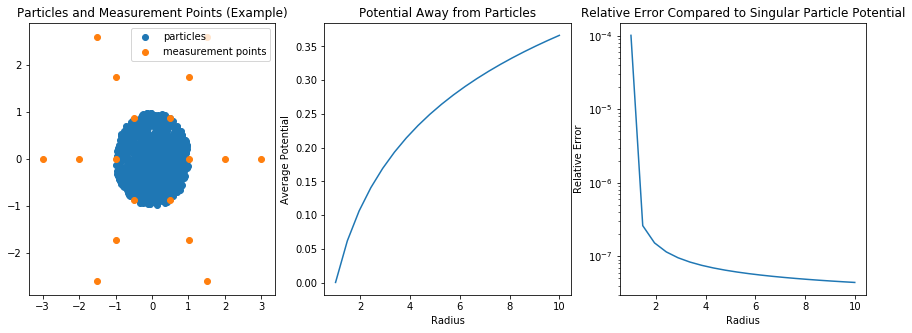

In [24]:
# Run an example of the alogrithm and display the output
# -- Parameters
N = 1000
low = 1.001
high = 10
R = 20
M = 100
iterations = 200

# -- Execute calculation
exact = single_centre_multi_radii(low, high, R)
# r, exper = plot_potential(low, high, R, M, N, iterations)
E = relative_error(exact, exper)

# Create a set of particles and measurement points
# for illustrative purposes only
y_ex = spawn_y(N)
x_ex = np.array([
    get_measurement_point(i//3, 6, i%3+1.001) for i in range(6*3)
])

# -- Plotting
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.scatter(y_ex[:, 0], y_ex[:, 1], label='particles')
ax1.scatter(x_ex[:, 0], x_ex[:, 1], label='measurement points')
ax1.legend()
ax1.set_title('Particles and Measurement Points (Example)')
ax2.plot(r, exper)
ax2.set_xlabel('Radius')
ax2.set_ylabel('Average Potential')
ax2.set_title('Potential Away from Particles')
ax3.semilogy(r, E)
ax3.set_xlabel('Radius')
ax3.set_ylabel('Relative Error')
ax3.set_title('Relative Error Compared to Singular Particle Potential')
fig.set_size_inches(15, 5)

In [22]:
# Measure the execution time of the main section of the
# procedure
%timeit fast_calculate_multi_radii(low, high, R, M, N, iterations)

740 ms ± 41.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Convergence

With the same method as in Q1, here we plot the largest abosolute difference between respective values of the radius across neighboring runs of the algorithm.

In [44]:
# Code to measure the convergence of the Potential Calculation alogrithm
def multirun_Q2(start, end, points, parameter):
    """
    Measure the runtime of the program for various values of the
    given parameter.
    """
    low = 1.001
    high = 10
    M = 300
    N = 1000
    R = 10
    iterations = 10000
    iterates = np.linspace(start, end, points)
    
    results = []
    
    for i, value in enumerate(iterates):
        if parameter == 'M':
            M = int(value)
        elif parameter == 'N':
            N = int(value)
        elif parameter == 'iterations':
            iterations = int(value)
        else:
            return
        print(M, N, iterations)
        results.append(
            fast_calculate_multi_radii(low, high, R, M, N, iterations)
        )
        
    return iterates, results


## -----------------------------------------------------------
## Uncomment this section to re-run convergence measurements
## -----------------------------------------------------------
N_space, N_res = multirun_Q2(10, 10000, 20, 'N')
print('N done')
M_space, M_res = multirun_Q2(10, 1000, 20, 'M')
print('M done')
iter_space, iter_res = multirun_Q2(5000, 20000, 20, 'iterations')
print('it. done')
N_space_plot, N_res_plot = difference_calculate(N_space, N_res)
M_space_plot, M_res_plot = difference_calculate(M_space, M_res)
iter_space_plot, iter_res_plot = difference_calculate(iter_space, iter_res)

300 10 10000
300 535 10000
300 1061 10000
300 1587 10000
300 2113 10000
300 2638 10000
300 3164 10000
300 3690 10000
300 4216 10000
300 4742 10000
300 5267 10000
300 5793 10000
300 6319 10000
300 6845 10000
300 7371 10000
300 7896 10000
300 8422 10000
300 8948 10000
300 9474 10000
300 10000 10000
N done
10 1000 10000
62 1000 10000
114 1000 10000
166 1000 10000
218 1000 10000
270 1000 10000
322 1000 10000
374 1000 10000
426 1000 10000
478 1000 10000
531 1000 10000
583 1000 10000
635 1000 10000
687 1000 10000
739 1000 10000
791 1000 10000
843 1000 10000
895 1000 10000
947 1000 10000
1000 1000 10000
M done
300 1000 5000
300 1000 5789
300 1000 6578
300 1000 7368
300 1000 8157
300 1000 8947
300 1000 9736
300 1000 10526
300 1000 11315
300 1000 12105
300 1000 12894
300 1000 13684
300 1000 14473
300 1000 15263
300 1000 16052
300 1000 16842
300 1000 17631
300 1000 18421
300 1000 19210
300 1000 20000
it. done


#### Saved Convergence Measurements
In the following cell, data generated by the above convergence measurement functions is copied for the sake of easy reproduction.

In [25]:
M_space_plot = np.array([ 62.10526316, 114.21052632, 166.31578947, 218.42105263,
       270.52631579, 322.63157895, 374.73684211, 426.84210526,
       478.94736842, 531.05263158, 583.15789474, 635.26315789,
       687.36842105, 739.47368421, 791.57894737, 843.68421053,
       895.78947368, 947.89473684])

M_res_plot = np.array([0.00017748142430269815,
 0.00023207665039622543,
 0.00023833851934390967,
 0.00018204666472269578,
 0.00014136928612513573,
 0.00036334305649951516,
 0.00014874564822349085,
 0.0002164405542107928,
 4.280513238656474e-05,
 2.9605125817370084e-05,
 1.081065571915444e-05,
 0.0003569116897119761,
 0.00016002467277349028,
 6.175459057989085e-05,
 0.00016845808222980377,
 0.00020309822820839982,
 0.00033500657685761094,
 7.170477005525225e-05])


N_space_plot = np.array([  60.20100503,  110.40201005,  160.60301508,  210.8040201 ,
        261.00502513,  311.20603015,  361.40703518,  411.6080402 ,
        461.80904523,  512.01005025,  562.21105528,  612.4120603 ,
        662.61306533,  712.81407035,  763.01507538,  813.2160804 ,
        863.41708543,  913.61809045,  963.81909548, 1014.0201005 ,
       1064.22110553, 1114.42211055, 1164.62311558, 1214.8241206 ,
       1265.02512563, 1315.22613065, 1365.42713568, 1415.6281407 ,
       1465.82914573, 1516.03015075, 1566.23115578, 1616.4321608 ,
       1666.63316583, 1716.83417085, 1767.03517588, 1817.2361809 ,
       1867.43718593, 1917.63819095, 1967.83919598, 2018.04020101,
       2068.24120603, 2118.44221106, 2168.64321608, 2218.84422111,
       2269.04522613, 2319.24623116, 2369.44723618, 2419.64824121,
       2469.84924623, 2520.05025126, 2570.25125628, 2620.45226131,
       2670.65326633, 2720.85427136, 2771.05527638, 2821.25628141,
       2871.45728643, 2921.65829146, 2971.85929648, 3022.06030151,
       3072.26130653, 3122.46231156, 3172.66331658, 3222.86432161,
       3273.06532663, 3323.26633166, 3373.46733668, 3423.66834171,
       3473.86934673, 3524.07035176, 3574.27135678, 3624.47236181,
       3674.67336683, 3724.87437186, 3775.07537688, 3825.27638191,
       3875.47738693, 3925.67839196, 3975.87939698, 4026.08040201,
       4076.28140704, 4126.48241206, 4176.68341709, 4226.88442211,
       4277.08542714, 4327.28643216, 4377.48743719, 4427.68844221,
       4477.88944724, 4528.09045226, 4578.29145729, 4628.49246231,
       4678.69346734, 4728.89447236, 4779.09547739, 4829.29648241,
       4879.49748744, 4929.69849246, 4979.89949749, 5030.10050251,
       5080.30150754, 5130.50251256, 5180.70351759, 5230.90452261,
       5281.10552764, 5331.30653266, 5381.50753769, 5431.70854271,
       5481.90954774, 5532.11055276, 5582.31155779, 5632.51256281,
       5682.71356784, 5732.91457286, 5783.11557789, 5833.31658291,
       5883.51758794, 5933.71859296, 5983.91959799, 6034.12060302,
       6084.32160804, 6134.52261307, 6184.72361809, 6234.92462312,
       6285.12562814, 6335.32663317, 6385.52763819, 6435.72864322,
       6485.92964824, 6536.13065327, 6586.33165829, 6636.53266332,
       6686.73366834, 6736.93467337, 6787.13567839, 6837.33668342,
       6887.53768844, 6937.73869347, 6987.93969849, 7038.14070352,
       7088.34170854, 7138.54271357, 7188.74371859, 7238.94472362,
       7289.14572864, 7339.34673367, 7389.54773869, 7439.74874372,
       7489.94974874, 7540.15075377, 7590.35175879, 7640.55276382,
       7690.75376884, 7740.95477387, 7791.15577889, 7841.35678392,
       7891.55778894, 7941.75879397, 7991.95979899, 8042.16080402,
       8092.36180905, 8142.56281407, 8192.7638191 , 8242.96482412,
       8293.16582915, 8343.36683417, 8393.5678392 , 8443.76884422,
       8493.96984925, 8544.17085427, 8594.3718593 , 8644.57286432,
       8694.77386935, 8744.97487437, 8795.1758794 , 8845.37688442,
       8895.57788945, 8945.77889447, 8995.9798995 , 9046.18090452,
       9096.38190955, 9146.58291457, 9196.7839196 , 9246.98492462,
       9297.18592965, 9347.38693467, 9397.5879397 , 9447.78894472,
       9497.98994975, 9548.19095477, 9598.3919598 , 9648.59296482,
       9698.79396985, 9748.99497487, 9799.1959799 , 9849.39698492,
       9899.59798995, 9949.79899497])


N_res_plot = np.array([0.0003168086508903728,
 0.0002650349733472346,
 0.0003592073138248446,
 0.00018440055312197176,
 9.495381313588436e-05,
 3.6583059686596186e-05,
 4.675194166722808e-05,
 0.00016051098577488419,
 3.2784182329048665e-05,
 0.00016055385745407394,
 0.00010060829777949295,
 0.00035074443275366195,
 0.00026978270152360005,
 4.19575158865513e-05,
 7.340426953424223e-05,
 0.00017441278589804178,
 0.0002363563499615671,
 0.00026955121776453723,
 0.00021357569923893935,
 8.029876458059473e-05,
 5.476720631336736e-05,
 7.375138997439657e-05,
 0.00011531036080768087,
 0.00010690614169443645,
 4.088666865727369e-05,
 4.23298704170837e-05,
 3.79343892464798e-05,
 0.00017410360190941654,
 0.00010689268368353996,
 1.698781425444897e-05,
 0.0001947173380031722,
 0.00021727202040522622,
 0.00013418004246946826,
 2.138654665728573e-05,
 9.177244970088166e-05,
 6.657305840305365e-05,
 8.540821921183821e-05,
 1.7900611605348067e-05,
 5.45855306547777e-05,
 0.00013528158903524973,
 2.480394394626185e-05,
 6.485901816571959e-05,
 4.044392898265362e-05,
 3.197231352388083e-05,
 8.798142770467339e-05,
 0.0001226897606250193,
 4.369639279712042e-05,
 2.653686247974177e-05,
 3.453916665865043e-05,
 6.945518672925236e-05,
 2.6022086588664257e-05,
 3.524912943907278e-05,
 4.115697980541456e-05,
 1.0993801696806534e-05,
 3.557557822043239e-05,
 3.4052267103362376e-05,
 5.849067429559169e-05,
 1.3559803153931157e-05,
 2.3055047664532537e-05,
 8.461159929374529e-06,
 9.231463100952287e-06,
 6.556430619241585e-05,
 6.193143182326431e-05,
 8.22286681802192e-05,
 0.00012053075509328948,
 0.00011667188886935011,
 8.611151944257332e-05,
 2.333858161887818e-05,
 2.65934251836969e-05,
 0.00012654303939826518,
 0.0001157426170186536,
 3.517705569336929e-05,
 6.0784669371878285e-05,
 3.781551977396646e-05,
 5.850645394933111e-06,
 0.0001365869607426957,
 0.00010845302306483883,
 1.2563575251985598e-05,
 3.1237751394051796e-05,
 3.9471288199377403e-05,
 1.975657513636246e-05,
 8.597683357152603e-05,
 5.131182520380581e-05,
 5.487902997406354e-05,
 1.761006830598209e-05,
 2.537803177815742e-05,
 2.745979068279473e-06,
 1.85194103413061e-05,
 3.760435458201242e-05,
 3.773002149063444e-05,
 3.0942085583859345e-05,
 1.5313625284965082e-05,
 3.886456158487817e-05,
 9.643370849120563e-05,
 5.752015410208012e-05,
 8.205600349054395e-06,
 8.315344965640406e-06,
 5.399600998757008e-05,
 8.540863476750793e-05,
 3.638046097155106e-05,
 4.3091139223446415e-05,
 1.3280496200379547e-05,
 9.8826877582328e-06,
 7.683843189441254e-05,
 8.959034114420571e-05,
 4.9417041080445514e-05,
 3.0469650011800718e-05,
 6.886082514716932e-05,
 1.1996171256550851e-05,
 4.7972503074339986e-05,
 1.5957152408311245e-05,
 1.6404115797252826e-05,
 1.2052711808901542e-05,
 3.7416555912801105e-05,
 6.699357048426137e-05,
 1.6357962023579796e-05,
 0.00012364054916835297,
 0.00011878500052716139,
 2.7529677253877833e-05,
 1.3756970694964521e-05,
 8.434078479862416e-06,
 2.0937019694929833e-05,
 8.242211770631501e-05,
 3.711347174564785e-05,
 5.444002187722116e-05,
 2.462348132929178e-05,
 5.516229212717661e-05,
 8.81126907561252e-05,
 2.0274861485884e-05,
 6.679937162241621e-05,
 6.303774517721838e-05,
 6.125266654642784e-05,
 9.714157619900105e-06,
 2.0323369895187246e-05,
 1.954659585124522e-05,
 7.093152084652468e-05,
 4.006736658683334e-05,
 7.858675299219882e-05,
 2.617247957780504e-05,
 2.431241746851025e-05,
 1.747564137370104e-05,
 1.793948709544911e-05,
 2.99676213570258e-05,
 1.831911972635116e-05,
 6.991766684826011e-05,
 3.9225698599110274e-05,
 0.00010177638646175302,
 0.00013255687172884363,
 7.342548528190313e-05,
 2.30535954193815e-05,
 1.515295900799446e-05,
 1.9022256259183065e-05,
 3.062256976764291e-05,
 6.132008132867883e-06,
 6.531474226791624e-05,
 3.6602344150668385e-05,
 2.363654006940457e-05,
 3.824901518531402e-05,
 1.1131245534730826e-05,
 2.3650402549034083e-05,
 2.4500383157485624e-05,
 2.0242000310684e-05,
 1.3965983662908528e-05,
 1.989575156903185e-05,
 2.066878488050383e-05,
 1.0876900334786861e-05,
 7.342986699782135e-05,
 1.1583205323052406e-05,
 3.978576658849685e-05,
 4.905838523533568e-05,
 2.0081440150544826e-05,
 3.1664370051003255e-05,
 6.218459640989043e-05,
 3.1390474147795255e-05,
 7.284411687683214e-06,
 6.450800118058291e-05,
 7.67257576220173e-05,
 2.6930737254365692e-05,
 2.661934019696177e-05,
 4.408012519540334e-05,
 1.173454159304968e-05,
 2.597813591571625e-05,
 4.102764504659876e-05,
 2.6508021170986728e-05,
 3.3350501504020865e-05,
 7.868427784238259e-05,
 2.4956868145033742e-05,
 4.000125499358331e-05,
 9.890274908400469e-06,
 2.3728349120773344e-05,
 3.842258351184116e-05,
 1.4549114206778018e-05,
 1.6923265458316387e-05,
 1.7942455741898886e-05,
 4.726454154846331e-06,
 2.4099274324497292e-05,
 3.118281507460087e-05,
 6.030930708200033e-05])

iter_space_plot = np.array([  30.1010101 ,   50.2020202 ,   70.3030303 ,   90.4040404 ,
        110.50505051,  130.60606061,  150.70707071,  170.80808081,
        190.90909091,  211.01010101,  231.11111111,  251.21212121,
        271.31313131,  291.41414141,  311.51515152,  331.61616162,
        351.71717172,  371.81818182,  391.91919192,  412.02020202,
        432.12121212,  452.22222222,  472.32323232,  492.42424242,
        512.52525253,  532.62626263,  552.72727273,  572.82828283,
        592.92929293,  613.03030303,  633.13131313,  653.23232323,
        673.33333333,  693.43434343,  713.53535354,  733.63636364,
        753.73737374,  773.83838384,  793.93939394,  814.04040404,
        834.14141414,  854.24242424,  874.34343434,  894.44444444,
        914.54545455,  934.64646465,  954.74747475,  974.84848485,
        994.94949495, 1015.05050505, 1035.15151515, 1055.25252525,
       1075.35353535, 1095.45454545, 1115.55555556, 1135.65656566,
       1155.75757576, 1175.85858586, 1195.95959596, 1216.06060606,
       1236.16161616, 1256.26262626, 1276.36363636, 1296.46464646,
       1316.56565657, 1336.66666667, 1356.76767677, 1376.86868687,
       1396.96969697, 1417.07070707, 1437.17171717, 1457.27272727,
       1477.37373737, 1497.47474747, 1517.57575758, 1537.67676768,
       1557.77777778, 1577.87878788, 1597.97979798, 1618.08080808,
       1638.18181818, 1658.28282828, 1678.38383838, 1698.48484848,
       1718.58585859, 1738.68686869, 1758.78787879, 1778.88888889,
       1798.98989899, 1819.09090909, 1839.19191919, 1859.29292929,
       1879.39393939, 1899.49494949, 1919.5959596 , 1939.6969697 ,
       1959.7979798 , 1979.8989899 ])

iter_res_plot = np.array([0.0014643559651488715,
 0.001326977953624956,
 0.0007687356358791103,
 0.0005563494762605126,
 0.0006631243322530476,
 0.0006582640125558909,
 0.0003286748791670257,
 0.0005626773026502602,
 6.39609651853627e-05,
 0.0006066566991537588,
 0.00031365600405483556,
 0.0003004463182959033,
 0.0004429994682677736,
 0.0006511333068954186,
 0.00012115589347279945,
 0.0001496026016615478,
 1.0515725445832341e-05,
 0.0004096326659311919,
 0.000730362719192564,
 0.0004631314586897502,
 0.00012978675711825801,
 8.949131036494624e-05,
 0.0002023877005574095,
 0.0003642781678278087,
 0.0002144828817950269,
 0.00022180322536785287,
 0.0004874387667416989,
 0.00043446715278025157,
 0.0002811139729599326,
 0.00067921562675302,
 0.0003209359751849408,
 0.00047369323954733555,
 7.777946521260309e-05,
 0.00020186318109366292,
 0.00045380889785424965,
 0.00019201555197337575,
 0.000252939143082015,
 0.0001756494969121951,
 2.54840728780478e-05,
 0.00030270199577564586,
 7.398017594769324e-05,
 0.00023623598350181287,
 0.00022560071610014872,
 0.00015537807800575988,
 0.00041378598125001647,
 0.00042745415620404256,
 5.878854702663564e-05,
 0.00010497309417084995,
 0.0003156141996056897,
 8.324379424447733e-05,
 0.00018660316241751068,
 0.00013996803599881257,
 0.0002639500698712717,
 0.00017751906810747095,
 7.146690997312204e-05,
 0.00027229738103993107,
 0.00031045028700964265,
 8.1125029202902e-05,
 0.00015305583750222445,
 0.0002356834261478112,
 0.00010680753334658487,
 0.00019929454410167315,
 5.175557036441171e-05,
 0.00010012079753910034,
 9.003663025856133e-05,
 6.369595592354084e-05,
 0.00026499867114545986,
 0.00037049918691068863,
 0.0002585479845833541,
 0.0001230693948147767,
 0.00014568358210386402,
 0.0002589347403023577,
 0.0005293618856554314,
 0.00011931621005700129,
 0.0003704975687953166,
 0.0003594316808859482,
 0.0002084598513273156,
 4.6087705436708507e-05,
 7.804409930146553e-05,
 0.00013106151455859105,
 0.00026376180090102914,
 5.86892853501622e-05,
 9.478901032290855e-05,
 0.00035309226542101454,
 8.681909502138275e-05,
 5.210829680115206e-05,
 0.00010166668372186398,
 0.0004048617801443191,
 0.00019093149219097174,
 0.00037994860339515374,
 0.00037195713531696235,
 0.000333883941474336,
 6.91307215467313e-05,
 0.00013717303658196297,
 0.00020726549336746671,
 0.00010248340568961104,
 0.00027829387219443656,
 0.0003513873878358266])

#### Convergence Plotting
Here we plot the convergence results calculated above.

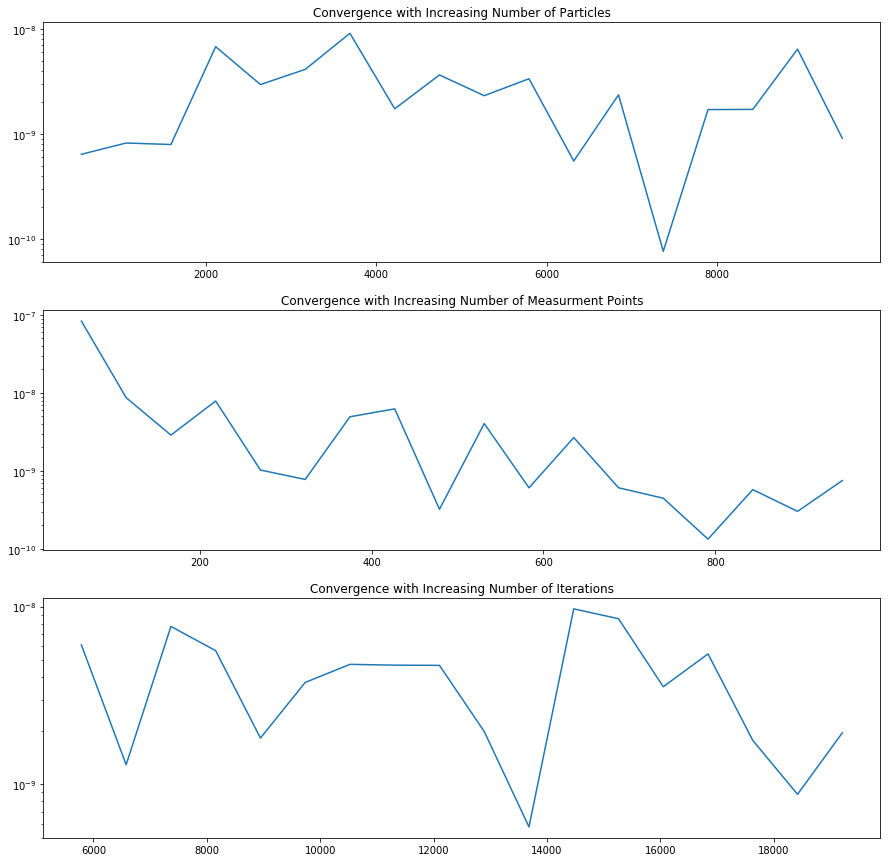

In [46]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1)
ax1.semilogy(N_space_plot, N_res_plot)
ax1.set_title('Convergence with Increasing Number of Particles')
ax2.semilogy(M_space_plot, M_res_plot)
ax2.set_title('Convergence with Increasing Number of Measurment Points')
ax3.semilogy(iter_space_plot, iter_res_plot)
ax3.set_title('Convergence with Increasing Number of Iterations')
fig.set_size_inches(15, 15)

#### Analysis of Convergence Results

* M
* N
* Number of iterations

# References

[1] https://stackoverflow.com/questions/5837572/generate-a-random-point-within-a-circle-uniformly/50746409#50746409
